In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/BSNIP'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['Age_cal'].keys()))
print(len(subs))

1244


In [45]:
import numpy as np

task = 'unk'
fc = []
sz = []
sex = []
race = []
age = []

for sub in subs:
    if demo['DXGROUP_2'][sub] not in ['SZP', 'NC', 'SZR', 'BPR', 'SADR']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    fc.append(p)
    sz.append(demo['DXGROUP_2'][sub] == 'SZP')
    age.append(int(demo['Age_cal'][sub]))
    sex.append(demo['sex'][sub] == 's1.0')
    race.append(demo['Race'][sub] == 'AA')
    
fc = np.stack(fc)
sz = np.array(sz).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
age = np.array(age)

print(fc.shape)
print(sz.shape)
print(sz[0:5])
print(age[0:5])

(934, 34716)
(934,)
[1 1 0 1 1]
[23 53 52 51 33]


In [76]:
import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/PNC_Good/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
fc = []
sex = []
race = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
    m = re.search('([^-]+)-(.*)', subtask)
#     m = re.search('([^-]+)', subtask)
    sub = m.group(1)
    task = m.group(2)
    a = demo['age_at_cnb'][sub]
    age.append(a)
    s = demo['Sex'][sub] == 'M'
    r = demo['Race'][sub] == 'AA'
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-{task}_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age)
fc = np.stack(fc)
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')

print([a.shape for a in [thetas, jitter, age, sex, race, fc]])
print(np.mean(age))

[(3849, 5, 264), (3849, 5, 264), (3849,), (3849,), (3849,), (3849, 34716)]
14.398285268901013


In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from itertools import chain

def rmse(yhat, y):
    if isinstance(yhat, np.ndarray) or isinstance(yhat, int):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

class Weights(nn.Module):
    def __init__(self, nsubs, dims):
        super(Weights, self).__init__()
        self.w = nn.Parameter(torch.randn(nsubs,dims).float().cuda())
        
    def compute(self, A, dims):
        self.project()
        return torch.einsum('nd,da->na',self.w[:,dims],A[dims])
    
    def project(self):
        with torch.no_grad():
            self.w[self.w < 0] = 1e-5
    
    def forward(self, A, dim):
#         return self.compute(A, torch.arange(dim+1))
        if dim > 0:
            with torch.no_grad():
                fixed = self.compute(A, torch.arange(dim))
            var = self.compute(A, torch.arange(dim,dim+1))
            xhat = torch.stack([fixed, var], axis=-1)
            return torch.sum(xhat, axis=-1)
        else:
            xhat = self.compute(A, torch.arange(0,1))
            return xhat

class Basis(nn.Module):
    def __init__(self, dims, rank):
        super(Basis, self).__init__()
        self.A = nn.Parameter(dims**0.5*torch.randn(dims,264,rank).float().cuda())
        
    def compute(self, dims):
        A = torch.einsum('dab,dcb->dac',self.A[dims],self.A[dims])
        a,b = torch.triu_indices(264,264,offset=1)
        A = A[:,a,b]
        A = F.normalize(A, dim=-1)
        return A
    
    def compute_all(self):
        return self.compute(torch.arange(self.A.shape[0]))
    
    def to_img(self, dims):
        A = self.compute(dims).detach().cpu()
        a,b = torch.triu_indices(264,264,offset=1)
        AA = torch.zeros(len(dims),264,264)
        AA[:,a,b] = A
        AA[:,b,a] = A
        return AA.squeeze().detach().cpu().numpy()
    
    def forward(self, dim):
        if dim > 0:
            with torch.no_grad():
                fixed = self.compute(torch.arange(dim))
            var = self.compute(torch.arange(dim,dim+1))
            A = torch.cat([fixed, var], axis=0)
            return A
        else:
            return self.compute(torch.arange(0,1))

xtr = torch.from_numpy(fc).float().cuda()

basis = Basis(10, 2)
weights = Weights(xtr.shape[0], 10)
optim = torch.optim.Adam(chain(basis.parameters(), weights.parameters()), lr=1e-1, weight_decay=0)

nepochs = 1000
pperiod = 100

for i in range(basis.A.shape[0]):
    if i > 0:
        nepochs = 200

    for e in range(nepochs):
        optim.zero_grad()
        b = basis(i)
        xhat = weights(b, i)
        loss = rmse(xhat, xtr)
        loss.backward()
        optim.step()
        if e % pperiod == 0 or e == nepochs:
            print(f'{e} {float(loss)} ')

print('Complete')

0 0.3695554733276367 
100 0.3215595483779907 
200 0.2821885943412781 
300 0.25312963128089905 
400 0.23186589777469635 
500 0.21702897548675537 
600 0.20721480250358582 
700 0.20103254914283752 
800 0.19728989899158478 
900 0.19509191811084747 
0 0.19386062026023865 
100 0.1871470957994461 
0 0.18718338012695312 
100 0.1836826205253601 
0 0.18371982872486115 
100 0.1816740483045578 
0 0.18163970112800598 
100 0.18022046983242035 
0 0.1802474409341812 
100 0.17849622666835785 
0 0.17853204905986786 
100 0.1775846928358078 
0 0.1775907576084137 
100 0.1767098605632782 
0 0.17674799263477325 
100 0.17619511485099792 
0 0.17623881995677948 
100 0.17575836181640625 
Complete


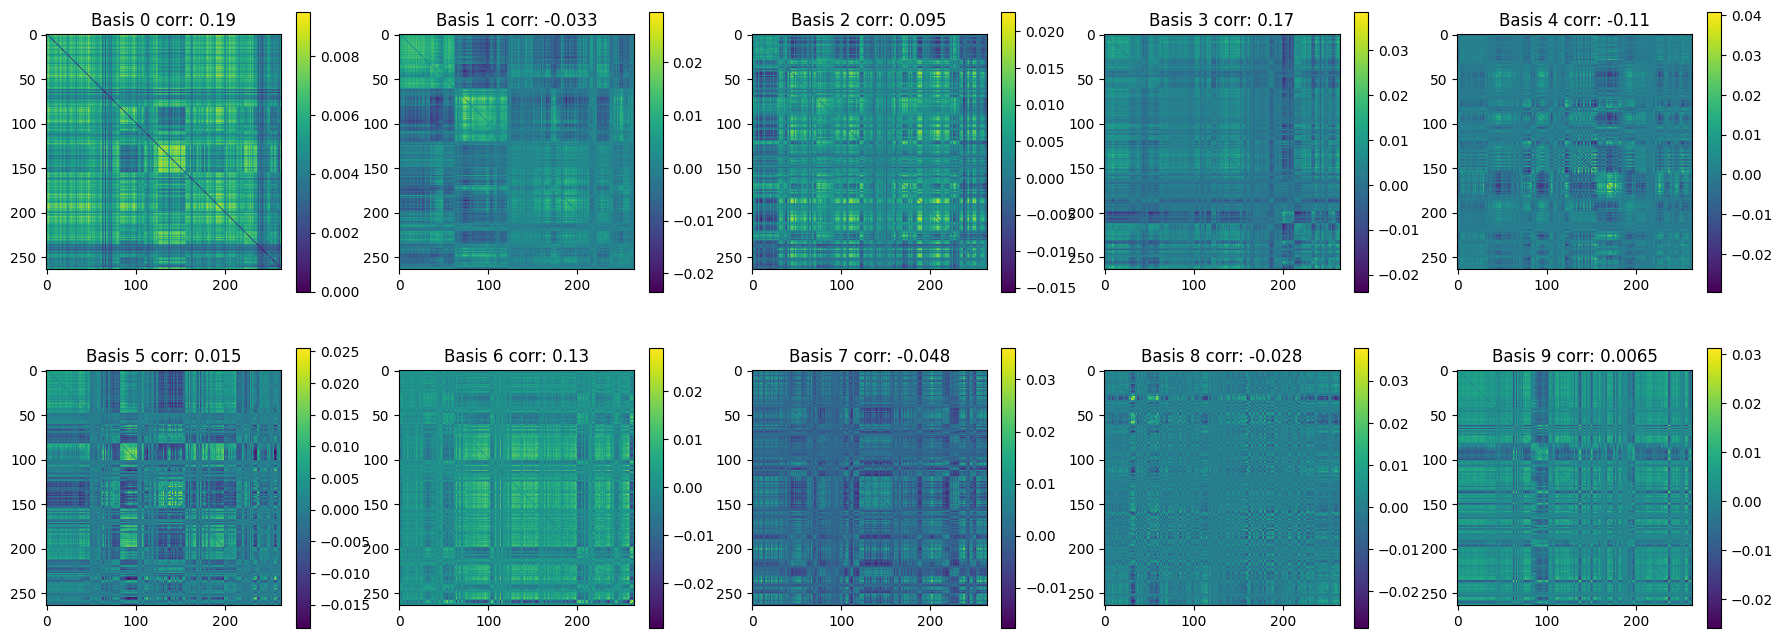

In [88]:
import matplotlib.pyplot as plt

def corr(x, y):
    x = x-np.mean(x, axis=0)
    y = y-np.mean(y, axis=0)
    syy = np.mean(y**2)
    sxx = np.mean(x**2, axis=0)
    sxy = np.einsum('nf,n->f', x, y)
    sxy /= x.shape[0]
    return sxy/(sxx*syy)**0.5

w = tonp(weights.w)
rho = corr(w[(age > 18)*(race == 0)], sex[(age > 18)*(race == 0)])

fig, ax = plt.subplots(2,5,figsize=(22,8))

for i in range(10):
    a,b = int(i/5),i%5
    im = ax[a,b].imshow(remap(basis.to_img(torch.arange(i,i+1))))
    fig.colorbar(im, ax=ax[a,b])
    ax[a,b].set_title(f'Basis {i} corr: {rho[i]:.2}')

fig.show()

In [73]:
def corr(x, y):
    x = x-np.mean(x, axis=0)
    y = y-np.mean(y, axis=0)
    syy = np.mean(y**2)
    sxx = np.mean(x**2, axis=0)
    sxy = np.einsum('nf,n->f', x, y)
    sxy /= x.shape[0]
    return sxy/(sxx*syy)**0.5

w = tonp(weights.w)
rho = corr(w, sz)
idcs = np.argsort(rho)
print(rho[idcs[:5]])
print(rho[idcs[-5:]])

[-0.11917315 -0.11067536 -0.10729208 -0.07781191 -0.04355994]
[0.13584007 0.14341554 0.16231191 0.16238209 0.19761939]


In [5]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [110]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split

def fromnp(x):
    return torch.from_numpy(x).float().cuda()

def tonp(x):
    return x.detach().cpu().numpy()

accs = []

a,b = np.triu_indices(10,1)

w = weights.w.detach()
x = w.unsqueeze(2)*w.unsqueeze(1)
x = tonp(x)
x = x[:,a,b]
x = np.concatenate([tonp(w)], axis=-1)

for _ in range(20):
    xtr, xt, ytr, yt = train_test_split(fc, age < 12, stratify=(age < 12), train_size=0.8)
    
    reg = LogisticRegression(C=1, max_iter=100).fit(xtr, ytr)
    yhat = reg.predict(xt)
    acc = np.mean(yhat == yt)
    prob = reg.predict_proba(xt)
    auc = roc_auc_score(yt, prob[:,-1])
    print(acc, auc)
    accs.append(auc)

#     mu = np.mean(ytr)
#     ytr -= mu
#     yt -= mu

#     reg = Ridge(alpha=1).fit(xtr, ytr)
#     yhat = reg.predict(xt)
#     acc = rmse(yhat, yt)
#     print(acc)
#     accs.append(acc)
    
print('---')
print(np.mean(accs), np.std(accs))

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.922077922077922 0.9713836214520438


/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9142857142857143 0.9632567188910921


KeyboardInterrupt: 